# SN2023ixf with Tx40

In this jupyter notebook, we are going to create the necessary code to complete the first part of the project called SN2023ixf. In this part it is going to be study the SN2023ixf data collected by the Tx40 telescope of OAJ.  

In [1]:
# Ejecution Time
import time
a = time.time()

# Packages
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.time import Time
from IPython.display import display, Math
import iminuit
from lmfit import Model, Parameters
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import statsmodels.api as sm
import smplotlib
import sncosmo
from tqdm import tqdm as tqdm

## 1. Data

We import the data of the supernova called SN2023ixf in the G, R and I filters, called, `Gsdss`, `Rsdss`, and `Isdss`, respectively. They contain magnitudes, each error, Julian time, and so on. Sufficient to plot the light curves. 

In [2]:
# Data
Gsdss = Table.read('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Tx40/SN2023ixf.Gsdss_A6B3.0001.fot', format='ascii') # G sloan filter
Rsdss = Table.read('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Tx40/SN2023ixf.Rsdss_A7B3.0001.fot', format='ascii') # R sloan filter
Isdss = Table.read('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Tx40/SN2023ixf.Isdss_A5B3.0001.fot', format='ascii') # I sloan filter

col_names = ['image_name', 'jd', 'mag', 'e_mag', 'filter'] # change columns names
Gsdss.rename_columns(Gsdss.colnames, col_names)
Rsdss.rename_columns(Rsdss.colnames, col_names)
Isdss.rename_columns(Isdss.colnames, col_names)

Gsdss[0:5]

image_name,jd,mag,e_mag,filter
str25,float64,float64,float64,str10
red_j03-20230526-0034.fit,2460091.618566,10.989,0.046364,Gsdss_A6B3
red_j03-20230526-0037.fit,2460091.621586,10.974,0.046352,Gsdss_A6B3
red_j03-20230529-0031.fit,2460094.39787,11.038,0.046429,Gsdss_A6B3
red_j03-20230529-0034.fit,2460094.39996,11.043,0.046416,Gsdss_A6B3
red_j03-20230529-0037.fit,2460094.402051,11.059,0.046416,Gsdss_A6B3


## 2. Plot light curve

We plot the light curves for each filter. 

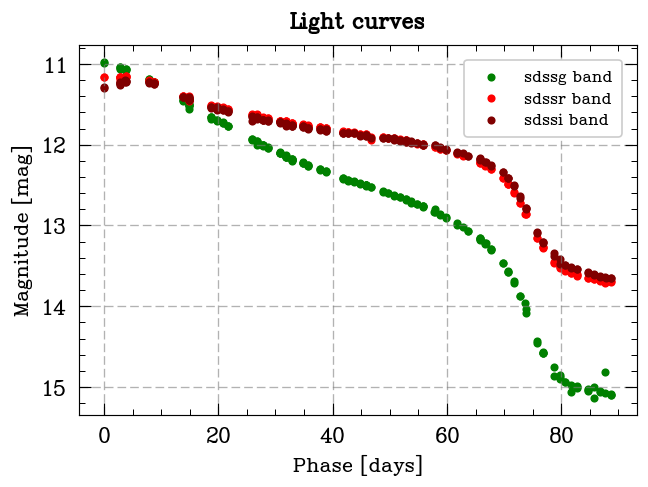

In [3]:
# Data
mag_G = Gsdss['mag']; mag_R = Rsdss['mag']; mag_I = Isdss['mag']
e_mag_G = Gsdss['e_mag']; e_mag_R = Rsdss['e_mag']; e_mag_I = Isdss['e_mag']
JD_G = Gsdss['jd']; JD_R = Rsdss['jd']; JD_I = Isdss['jd']

# Julian Dates (JD) to days with t = 0 days set as first measure
times_G = Time(Time(JD_G, format='jd').strftime('%Y-%m-%d %H:%M:%S'), format='iso'); times_R = Time(Time(JD_R, format='jd').strftime('%Y-%m-%d %H:%M:%S'), format='iso'); times_I = Time(Time(JD_I, format='jd').strftime('%Y-%m-%d %H:%M:%S'), format='iso')
time_deltas_G = times_G - times_G[0]; time_deltas_R = times_R - times_R[0]; time_deltas_I = times_I - times_I[0]
days_since_start_G = time_deltas_G.to_value('jd'); days_since_start_R = time_deltas_R.to_value('jd'); days_since_start_I = time_deltas_I.to_value('jd')

# Light curves
plt.figure(figsize=(6, 4))

plt.scatter(days_since_start_G, mag_G, color = 'green', label = 'sdssg band', s = 15)
plt.scatter(days_since_start_R, mag_R, color = 'red', label = 'sdssr band', s = 15)
plt.scatter(days_since_start_I, mag_I, color = 'maroon', label = 'sdssi band', s = 15)

#plt.errorbar(0,15,yerr=np.mean(e_mag_G),color="green",elinewidth=1,capsize=2)
#plt.errorbar(5,15,yerr=np.mean(e_mag_R),color="red",elinewidth=1,capsize=2)
#plt.errorbar(10,15,yerr=np.mean(e_mag_I),color="maroon",elinewidth=1,capsize=2)

plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Light curves', fontsize=16, fontweight='bold')

plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize = 11, frameon = True)

plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/light_curve_SN2023ixf_Tx40.pdf', dpi=600, bbox_inches='tight')
plt.show()

## 3. Fit light curve

In this section, we are going to fit the light curves for the three filters.

### 3.1. nugent-sn2p model

We are going to use the package `sncosmo` from Python for the light curves. Specifically, we are going to employ the `nugent-sn2p` model since it is prepared for SN-IIP (the type of SN2023ixf) and its pull is the less one found compared with other SN-IIP models. Besides, the famous `salt2` model cannot be used because it was made for SNIa types. 

Note: We have to transform the magnitudes columns and each error into fluxes assuming a zeropoint (sncosmos need it), that is to say, 

\begin{equation}
    F_1 = 10^{-\frac{(m_1-zp)}{2.5}}\,,
\end{equation}

where _zp_ is the zeropoint chosen, `zp`, and $F_2$ = 1. This methodology is just applied to 'normalize' the fluxes to a low value to reduce the computational effort when calculating the fit with `sncosmo.mcmc_lc`. In other words, it assumes that a flux equivalent to 1 corresponds to a magnitude of `zp` in the AB system. 

In [4]:
# Model 
model = sncosmo.Model(source='nugent-sn2p') # probar con 2P
model.set(z=0.00804)

zp = 10.0 # zero-point

# Join tables
data_GRI = vstack([Gsdss, Rsdss, Isdss])

# Fix data table to sncosmo table templete
mapping = {
    'Gsdss_A6B3': 'sdssg',
    'Rsdss_A7B3': 'sdssr',
    'Isdss_A5B3': 'sdssi'
}

# Aplicar el mapeo a la columna 'filter'
data_GRI['jd']=data_GRI['jd']
data_GRI['flux']= 10**(-(data_GRI['mag']-zp)/2.5) 
data_GRI['fluxerr']= 10**(-(data_GRI['mag']-zp)/2.5) * np.log(10) * (0.4) * data_GRI['e_mag']
data_GRI['filter'] = [mapping.get(filter_value, filter_value) for filter_value in data_GRI['filter']]
data_GRI['zp']=zp,  # zero-point
data_GRI['zpsys']='ab'  # magnitude system

data_GRI.remove_column('mag')
data_GRI.remove_column('e_mag')
filter_column = data_GRI['filter']
data_GRI.remove_column('filter')
data_GRI.add_column(filter_column, index=4)

data_GRI[0:5]

image_name,jd,flux,fluxerr,filter,zp,zpsys
str25,float64,float64,float64,str5,float64,str2
red_j03-20230526-0034.fit,2460091.618566,0.40216104433421307,0.01717341153200763,sdssg,10.0,ab
red_j03-20230526-0037.fit,2460091.621586,0.40775566175021233,0.017407810802124148,sdssg,10.0,ab
red_j03-20230529-0031.fit,2460094.39787,0.38441471175957775,0.01643860688633981,sdssg,10.0,ab
red_j03-20230529-0034.fit,2460094.39996,0.3826484865951098,0.01635849672872911,sdssg,10.0,ab
red_j03-20230529-0037.fit,2460094.402051,0.37705091583339323,0.016119196571529583,sdssg,10.0,ab


In [5]:
# sncosmo model
bounds = {  
    't0': (2100000, 2500000),  
    'amplitude': (1e-12, 1e-6)  
}

result, fitted_model = sncosmo.mcmc_lc(data_GRI, model, ['t0', 'amplitude'], bounds=bounds)

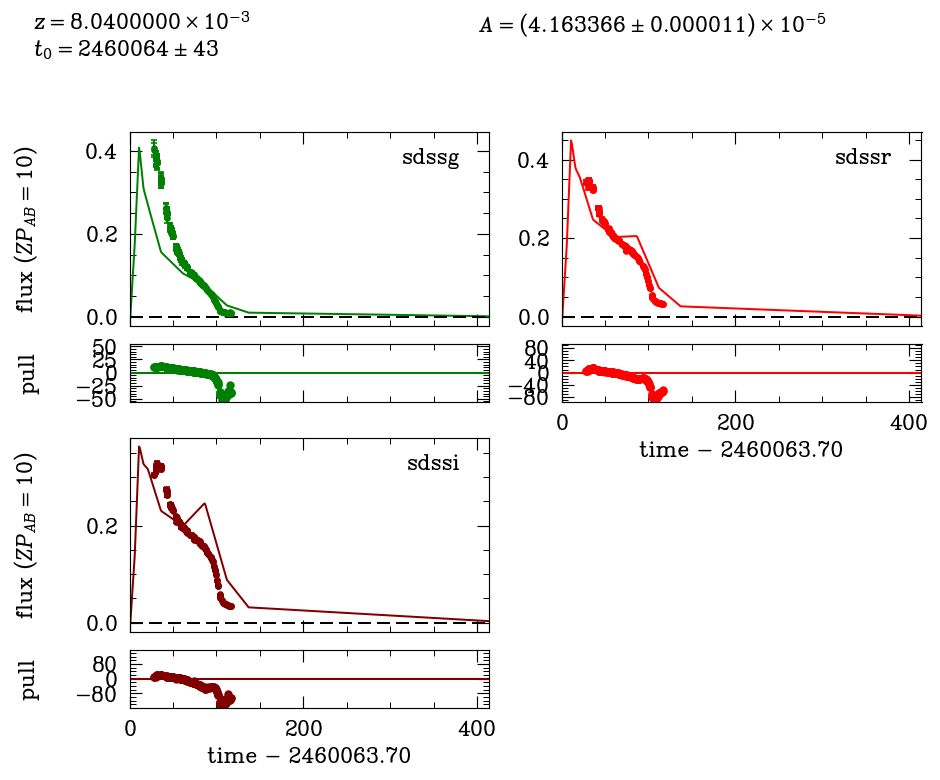

In [6]:
# Colors
custom_colors = ['maroon', 'maroon', 'red','green']
cmap = ListedColormap(custom_colors)

sncosmo.plot_lc(data_GRI, model=fitted_model, errors=result.errors, cmap=cmap, zp=10)

plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/sncosmofit_light_curve_SN2023ixf_Tx40.pdf', dpi=600, bbox_inches='tight')
plt.show()

### 3.2. Decay model

In this case, we are going to use the "[Bazin function](https://arxiv.org/pdf/1701.05689)" to fit the light curve of the supernovae.

\begin{equation}
    f(t) = A \cdot \frac{e^{-(t-t_0)/\tau_{fall}}}{1+e^{(t-t_0)/\tau_{rise}}} + B
\end{equation}

We have to fit the A, B, $\tau_{fall}$, $\tau_{rise}$ and $t_0$ parameters. For this, we are going to apply the `lmfit` package from Python. First, we report the fit results in a cell. See this [paper](https://arxiv.org/pdf/1701.05689) to understand de physics of the parameters.

In [7]:
# function to fit (light curve)
def light_curve(t, A, B, tau_fall, tau_rise, t_0):
    return A * (np.exp(-(t - t_0) / tau_fall)) / (1 + np.exp((t - t_0) / tau_rise)) + B

# model
model = Model(light_curve)

# inital conditions of the parameters
params = model.make_params(A=1, B=1, tau_fall=1, tau_rise=1, t_0=1)

# fit parameters
result_G = model.fit(mag_G, params, t=days_since_start_G, weights = 1/e_mag_G)
result_R = model.fit(mag_R, params, t=days_since_start_R, weights = 1/e_mag_R)
result_I = model.fit(mag_I, params, t=days_since_start_I, weights = 1/e_mag_I)

# results
print('Band g as an example of the results of the fit:\n')
print(result_G.fit_report())

Band g as an example of the results of the fit:

[[Model]]
    Model(light_curve)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1018
    # data points      = 190
    # variables        = 5
    chi-square         = 109.685018
    reduced chi-square = 0.59289199
    Akaike info crit   = -94.3881440
    Bayesian info crit = -78.1530236
    R-squared          = 0.55962244
[[Variables]]
    A:        -1.88719643 +/- 0.01152245 (0.61%) (init = 1)
    B:         15.0827480 +/- 0.01055185 (0.07%) (init = 1)
    tau_fall:  2.78681513 +/- 0.05925846 (2.13%) (init = 1)
    tau_rise: -2.87253153 +/- 0.06260667 (2.18%) (init = 1)
    t_0:       74.1000604 +/- 0.07917410 (0.11%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau_fall, tau_rise) = -1.0000
    C(A, B)               = -0.8353
    C(A, tau_fall)        = -0.6303
    C(B, t_0)             = +0.6293
    C(A, tau_rise)        = +0.6248
    C(B, tau_fall)        = +0.5691
    C(B, tau_

We calculate also the $\chi^2/d.o.f$ and A(Y) and A(u) parameters to sutyd the quality of the cuts. 

In [8]:
# Parameters
dof_G = len(mag_G) - 5 # degrees of freedom -> number of parameters
dof_R = len(mag_R) - 5
dof_I = len(mag_I) - 5

chi2_dof_G = result_G.chisqr/dof_G
chi2_dof_R = result_G.chisqr/dof_R
chi2_dof_I = result_G.chisqr/dof_I

# x²/d.o.f < 10 ?
if chi2_dof_G < 10:
    print('The condition chi2/dof < 10 is met for band G')
else:
    print('The condition chi2/dof < 10 is not met for band G')

if chi2_dof_R < 10:
    print('The condition chi2/dof < 10 is met for band R')
else:
    print('The condition chi2/dof < 10 is not met for band R')

if chi2_dof_I < 10:
    print('The condition chi2/dof < 10 is met for band I')
else:
    print('The condition chi2/dof < 10 is not met for band I')

The condition chi2/dof < 10 is met for band G
The condition chi2/dof < 10 is met for band R
The condition chi2/dof < 10 is met for band I


In this case, we should obtain t_{rise}>1, but this is not possible in our case because we have measures since the maximum. Therefore, this SN should be excluded from the study, according to the quality cuts from [paper](https://arxiv.org/pdf/1701.05689).

Then, we calculate the associated error of the fit to represent them as a shadow in the plot.

In [9]:
# Erros of the fits
params_G = result_G.params; params_R = result_R.params; params_I = result_I.params

errors_G = {key: value.stderr for key, value in params_G.items()}
errors_R = {key: value.stderr for key, value in params_R.items()}
errors_I = {key: value.stderr for key, value in params_I.items()}

# Function to obtain errors
def get_error_bands(params, x, errors, model_func):
    y_fit = model_func(x, **params)
    y_errs = {k: v * np.abs(y_fit) for k, v in errors.items()}  # Error propagado
    return y_fit - y_errs['A'], y_fit + y_errs['A']

# Shadows -- erros
x_fit_G = np.linspace(min(days_since_start_G), max(days_since_start_G), 1000)
y_fit_G = light_curve(x_fit_G, **result_G.params.valuesdict())
y_lower_G, y_upper_G = get_error_bands(result_G.params.valuesdict(), x_fit_G, errors_G, light_curve)

x_fit_R = np.linspace(min(days_since_start_R), max(days_since_start_R), 1000)
y_fit_R = light_curve(x_fit_R, **result_G.params.valuesdict())
y_lower_R, y_upper_R = get_error_bands(result_R.params.valuesdict(), x_fit_R, errors_R, light_curve)

x_fit_I = np.linspace(min(days_since_start_I), max(days_since_start_I), 1000)
y_fit_I = light_curve(x_fit_I, **result_I.params.valuesdict())
y_lower_I, y_upper_I = get_error_bands(result_I.params.valuesdict(), x_fit_I, errors_I, light_curve)

Lastly, we represent the final fits with their errors as shadows.

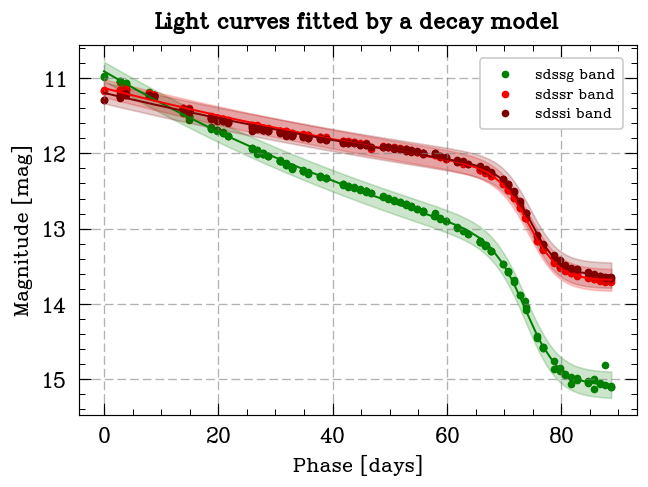

In [10]:
# Plot results
plt.figure(figsize=(6, 4))

plt.scatter(days_since_start_G, mag_G, color = 'green', label = 'sdssg band', s = 13) # g band
plt.plot(days_since_start_G, result_G.best_fit, 'green', linestyle = '-') # g band fit
plt.fill_between(x_fit_G, y_lower_G, y_upper_G, color='green', alpha=0.2) # shadow error

plt.scatter(days_since_start_R, mag_R, color = 'red', label = 'sdssr band', s = 13) # r band
plt.plot(days_since_start_R, result_R.best_fit, 'red') # g band fit
plt.fill_between(x_fit_R, y_lower_R, y_upper_R, color='red', alpha=0.2) # shadow error

plt.scatter(days_since_start_I, mag_I, color = 'maroon', label = 'sdssi band', s = 13) # i band
plt.plot(days_since_start_I, result_I.best_fit, 'maroon') # i band fit
plt.fill_between(x_fit_I, y_lower_I, y_upper_I, color='maroon', alpha=0.2) # shadow error

plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Light curves fitted by a decay model', fontsize=16, fontweight='bold')

plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize = 10, frameon = True)

plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/lmfit_light_curve_SN2023ixf_Tx40.pdf', dpi=600, bbox_inches='tight')
plt.show()

Finally, we plot the different parameters of the "[Bazin function](https://arxiv.org/pdf/1701.05689))" to compare between them in each band.

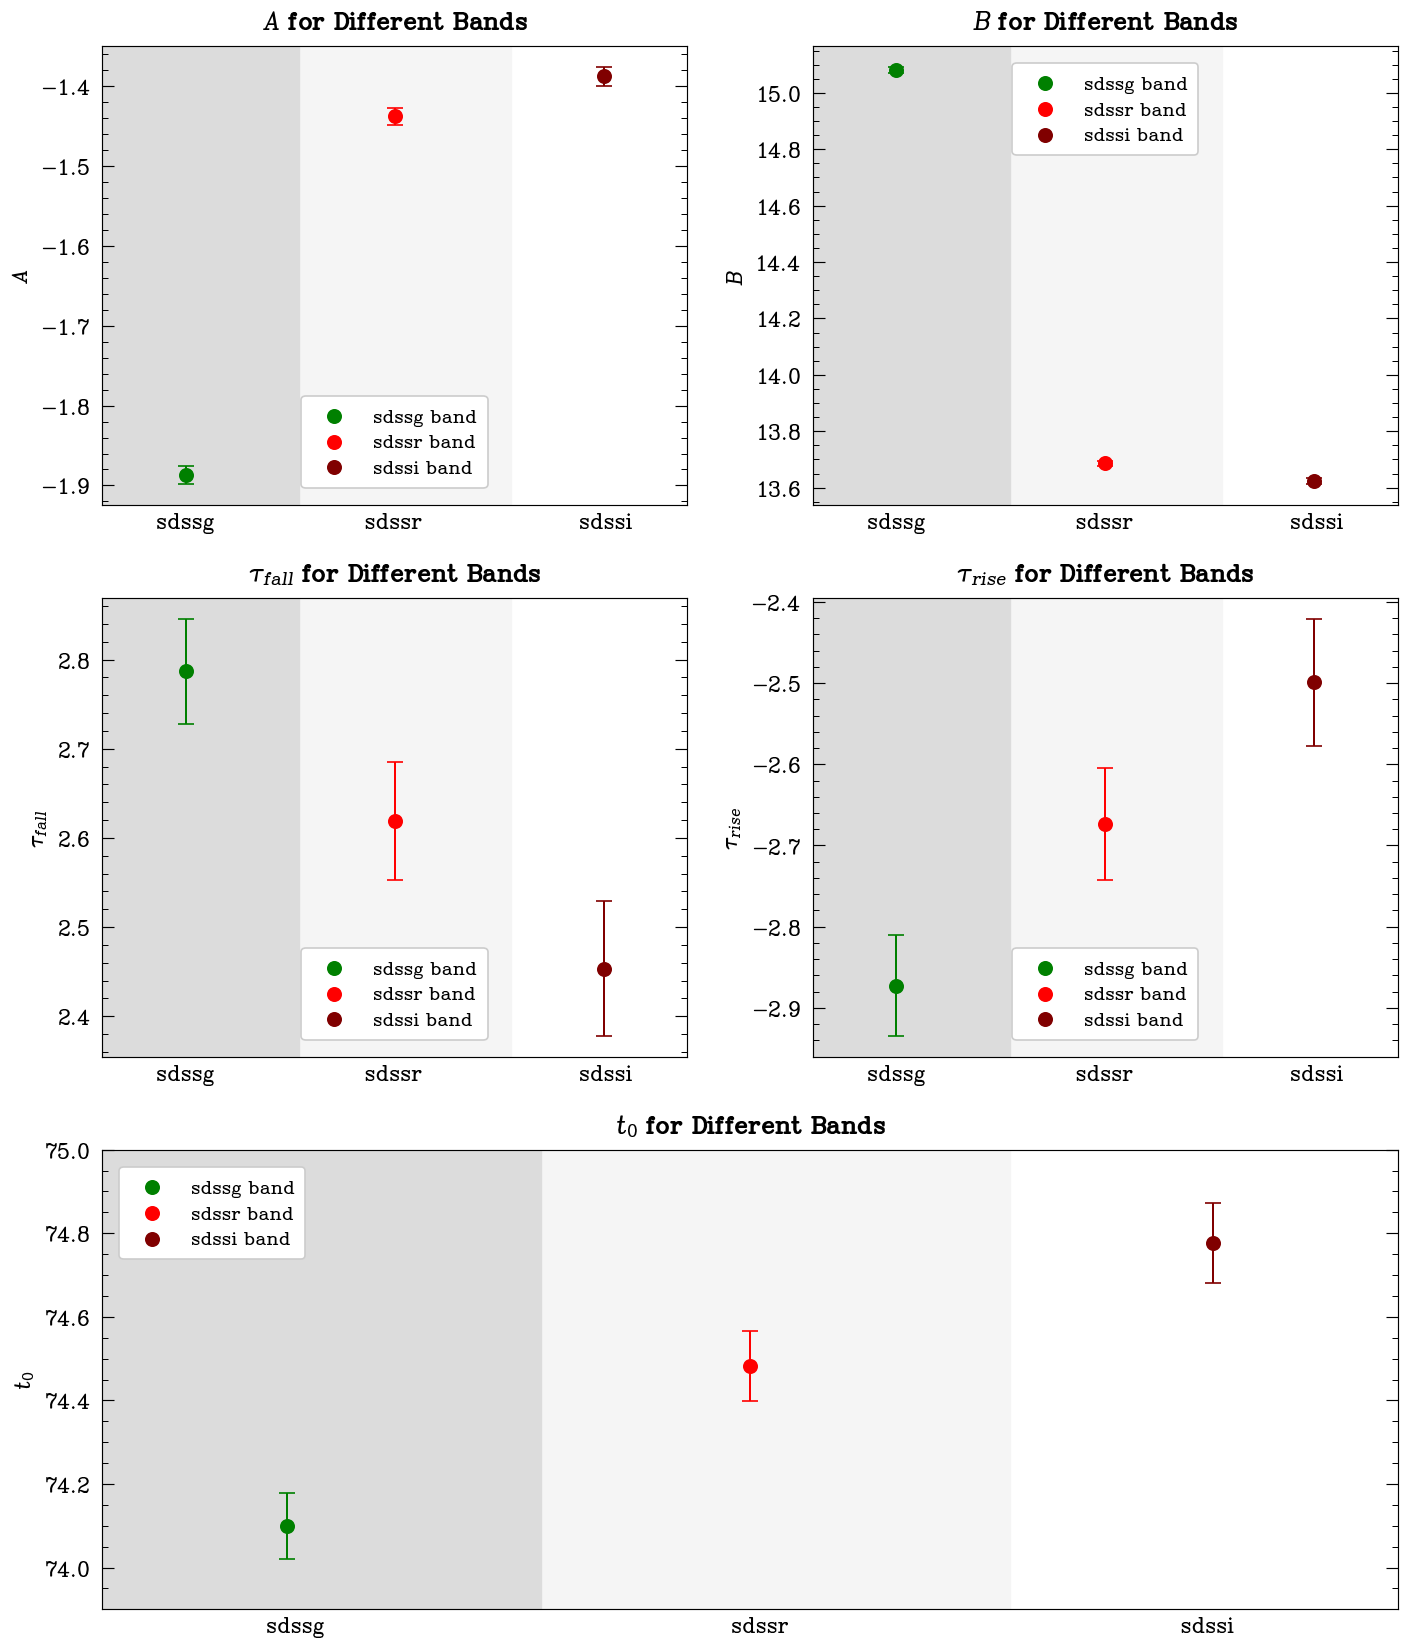

In [11]:
# Extract parameters for each band
def extract_parameters(result):
    params = result.params
    param_values = {name: param.value for name, param in params.items()}
    param_errors = {name: param.stderr for name, param in params.items()}
    return param_values, param_errors

values_G, errors_G = extract_parameters(result_G)
values_R, errors_R = extract_parameters(result_R)
values_I, errors_I = extract_parameters(result_I)

# Plot
fig = plt.figure(figsize=(12, 14))
gs = fig.add_gridspec(3, 2)

param_names = ['A', 'B', 'tau_fall', 'tau_rise', 't_0']
param_name2 = [r'A',r'B',r'\tau_{fall}',r'\tau_{rise}',r't_0']
colors = {'sdssg': 'green', 'sdssr': 'red', 'sdssi': 'maroon'}

axs = []

for i in range(len(param_names)):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    axs.append(ax)

    values = [values_G[param_names[i]], values_R[param_names[i]], values_I[param_names[i]]]
    errors = [errors_G[param_names[i]], errors_R[param_names[i]], errors_I[param_names[i]]]

    bands = ['sdssg', 'sdssr', 'sdssi']
    band_colors = [colors[band] for band in bands]

    for j, band in enumerate(bands):
        axs[i].scatter(band, values[j], color=band_colors[j], label=f'{band} band')
        axs[i].errorbar(band, values[j], yerr=errors[j], fmt='o', color=band_colors[j], capsize=5)

    y_min, y_max = axs[i].get_ylim()

    axs[i].axhspan(y_min, y_max, xmin=0, xmax=0.34, color = 'gainsboro')
    axs[i].axhspan(y_min, y_max, xmin=0.34, xmax=0.705, color = 'whitesmoke')
    axs[i].axhspan(y_min, y_max, xmin=0.702, xmax=1, color = 'white')
    
    axs[i].set_ylim(y_min,y_max)
    axs[i].set_title(f'${param_name2[i]}$ for Different Bands', fontweight='bold')
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel(f'${param_name2[i]}$')
    axs[i].legend(fontsize=13, frameon=True)
    #axs[i].grid()

    if i != len(param_names) - 1:
        axs[i].set_xticks([])
        axs[i].set_xlabel('sdssg                     sdssr                      sdssi')
        axs[i].set_xlim(-0.4,2.4)


# Remove the extra subplot and add a new one centered
fig.delaxes(axs[-1])
ax_centered = fig.add_subplot(gs[-1, :])
axs.append(ax_centered)

values = [values_G[param_names[-1]], values_R[param_names[-1]], values_I[param_names[-1]]]
errors = [errors_G[param_names[-1]], errors_R[param_names[-1]], errors_I[param_names[-1]]]

for j, band in enumerate(bands):
    ax_centered.scatter(band, values[j], color=band_colors[j], label=f'{band} band')
    ax_centered.errorbar(band, values[j], yerr=errors[j], fmt='o', color=band_colors[j], capsize=5)

ax_centered.axhspan(73, 76, xmin=0, xmax=0.34, color = 'gainsboro')
ax_centered.axhspan(73, 76, xmin=0.34, xmax=0.705, color = 'whitesmoke')
ax_centered.axhspan(73, 76, xmin=0.702, xmax=1, color = 'white')

ax_centered.set_xlim(-0.4,2.4)
ax_centered.set_ylim(73.9, 75)
ax_centered.set_title(f'${param_name2[-1]}$ for Different Bands', fontweight='bold')  
ax_centered.set_xlabel('sdssg                                                         sdssr                                                       sdssi')
ax_centered.set_ylabel(f'${param_name2[-1]}$')
ax_centered.legend(fontsize=13, frameon=True)
ax_centered.set_xticks([])
#ax_centered.grid()

plt.tight_layout()
plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/parameters_light_curve_SN2023ixf_Tx40.pdf', dpi=600, bbox_inches='tight')
plt.show()

### 3.3. $\Delta m_{15}$ parameter

We finally calculate the $\Delta m_{15}$ parameter to complete the estimation of the different parameters of SN2023ixf. This parameter is defined as the difference in B-magnitude between the peak of light of the SN and its magnitude 15 days after. The relations state that the maximum intrinsic B-band magnitude is given by

\begin{equation}
    M_{B,max} = -21.726 + 2.698 \cdot \Delta m_{B,15} \, .
\end{equation}

Note: Relation extracted from this [paper](https://articles.adsabs.harvard.edu/pdf/1993ApJ...413L.105P).

Since we do not have the absolute magnitude of the curve light, we can just calculate it as $\Delta m_{15}$ = $m_{B, peak}$ - $m_{B, 15}$. Important to note that this is the difference in the b-band and from t = 0$\,$days (peak) to t = 15$\,$days. On the other hand, since we do not have data for the b-band, we use the g-band as it is the closest. In this way, we obtain an estimate of this parameter even if it is not accurate.

In [12]:
# Errors of Delta m_15
def find_closest_index(array, value):
    return np.abs(array - value).argmin()

# e_m15 - gsdss
index_0_G = find_closest_index(x_fit_G, 0)
index_15_G = find_closest_index(x_fit_G, 15)

y_upper_at_0_G = y_upper_G[index_0_G]; y_lower_at_0_G = y_lower_G[index_0_G]; error_0_G = (y_upper_at_0_G - y_lower_at_0_G)/2
y_upper_at_15_G = y_upper_G[index_15_G]; y_lower_at_15_G = y_lower_G[index_15_G]; error_15_G = (y_upper_at_15_G - y_lower_at_15_G)/2
e_Delta_m_15_G = np.sqrt(error_0_G**2 + error_15_G**2)

# e_m15 - rsdss
index_0_R = find_closest_index(x_fit_R, 0)
index_15_R = find_closest_index(x_fit_R, 15)

y_upper_at_0_R = y_upper_R[index_0_R]; y_lower_at_0_R = y_lower_R[index_0_R]; error_0_R = (y_upper_at_0_R - y_lower_at_0_R)/2
y_upper_at_15_R = y_upper_R[index_15_R]; y_lower_at_15_R = y_lower_R[index_15_R]; error_15_R = (y_upper_at_15_R - y_lower_at_15_R)/2
e_Delta_m_15_R = np.sqrt(error_0_R**2 + error_15_R**2)

# e_m15 - isdss
index_0_I = find_closest_index(x_fit_I, 0)
index_15_I = find_closest_index(x_fit_I, 15)

y_upper_at_0_I = y_upper_I[index_0_I]; y_lower_at_0_I = y_lower_I[index_0_I]; error_0_I = (y_upper_at_0_I - y_lower_at_0_I)/2
y_upper_at_15_I = y_upper_I[index_15_I]; y_lower_at_15_I = y_lower_I[index_15_I]; error_15_I = (y_upper_at_15_I - y_lower_at_15_I)/2
e_Delta_m_15_I = np.sqrt(error_0_I**2 + error_15_I**2)

In [13]:
# m15 - gsdss
A_G = result_G.params['A'].value
B_G = result_G.params['B'].value
tau_fall_G = result_G.params['tau_fall'].value
tau_rise_G = result_G.params['tau_rise'].value
t_0_G = result_G.params['t_0'].value

m_G_0 = light_curve(0, A_G, B_G, tau_fall_G, tau_rise_G, t_0_G)
m_G_15 = light_curve(15, A_G, B_G, tau_fall_G, tau_rise_G, t_0_G)

Delta_m_15_G = m_G_15 - m_G_0
e_Delta_m_15_G = e_Delta_m_15_G
text1 = r'\text{The value of the } $$\Delta m_{15}$$ \text{ parameter is }' + f'{np.round(Delta_m_15_G,2)}' + f' \pm {np.round(e_Delta_m_15_G,2)}'
display(Math(text1))

# m15 - rsdss
A_R = result_R.params['A'].value
B_R = result_R.params['B'].value
tau_fall_R = result_R.params['tau_fall'].value
tau_rise_R = result_R.params['tau_rise'].value
t_0_R = result_R.params['t_0'].value

m_R_0 = light_curve(0, A_R, B_R, tau_fall_R, tau_rise_R, t_0_R)
m_R_15 = light_curve(15, A_R, B_R, tau_fall_R, tau_rise_R, t_0_R)

Delta_m_15_R = m_R_15 - m_R_0
e_Delta_m_15_R = e_Delta_m_15_R
text2 = r'\text{The value of the } $$\Delta m_{15}$$ \text{ parameter is }' + f'{np.round(Delta_m_15_R,2)}' + f' \pm {np.round(e_Delta_m_15_R,2)}'
display(Math(text2))

# m15 - isdss
A_I = result_I.params['A'].value
B_I = result_I.params['B'].value
tau_fall_I = result_I.params['tau_fall'].value
tau_rise_I = result_I.params['tau_rise'].value
t_0_I = result_I.params['t_0'].value

m_I_0 = light_curve(0, A_I, B_I, tau_fall_I, tau_rise_I, t_0_I)
m_I_15 = light_curve(15, A_I, B_I, tau_fall_I, tau_rise_I, t_0_I)

Delta_m_15_I = m_I_15 - m_I_0
e_Delta_m_15_I = e_Delta_m_15_I
text3 = r'\text{The value of the } $$\Delta m_{15}$$ \text{ parameter is }' + f'{np.round(Delta_m_15_I,2)}' + f' \pm {np.round(e_Delta_m_15_I,2)}'
display(Math(text3))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
# Ejectuoon Time
b = time.time()
print(np.round((b-a)/60,2),'min of execution')

0.38 min of execution
